In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

ca_housing_path = "Resources/CA_Housing_Data.csv"

ca_housing_data = pd.read_csv(ca_housing_path)

ca_housing_data.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,NEAR BAY,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY,342200


In [20]:
Near_Bay_Pop = ca_housing_data.loc[ca_housing_data["ocean_proximity"] == "NEAR BAY", "population"].mean()
Inland_Pop = ca_housing_data.loc[ca_housing_data["ocean_proximity"] == "INLAND", "population"].mean()
Under_Hour_Pop = ca_housing_data.loc[ca_housing_data["ocean_proximity"] == "<1H OCEAN", "population"].mean()
Near_Ocean_Pop = ca_housing_data.loc[ca_housing_data["ocean_proximity"] == "NEAR OCEAN", "population"].mean()
Island_pop = ca_housing_data.loc[ca_housing_data["ocean_proximity"] == "ISLAND", "population"].mean()

print(Near_Ocean_Pop)
print(Near_Bay_Pop)
print(Inland_Pop)
print(Under_Hour_Pop)
print(Island_pop)

1354.0086531226486
1230.3174672489083
1391.0462524805373
1520.2904991243433
668.0


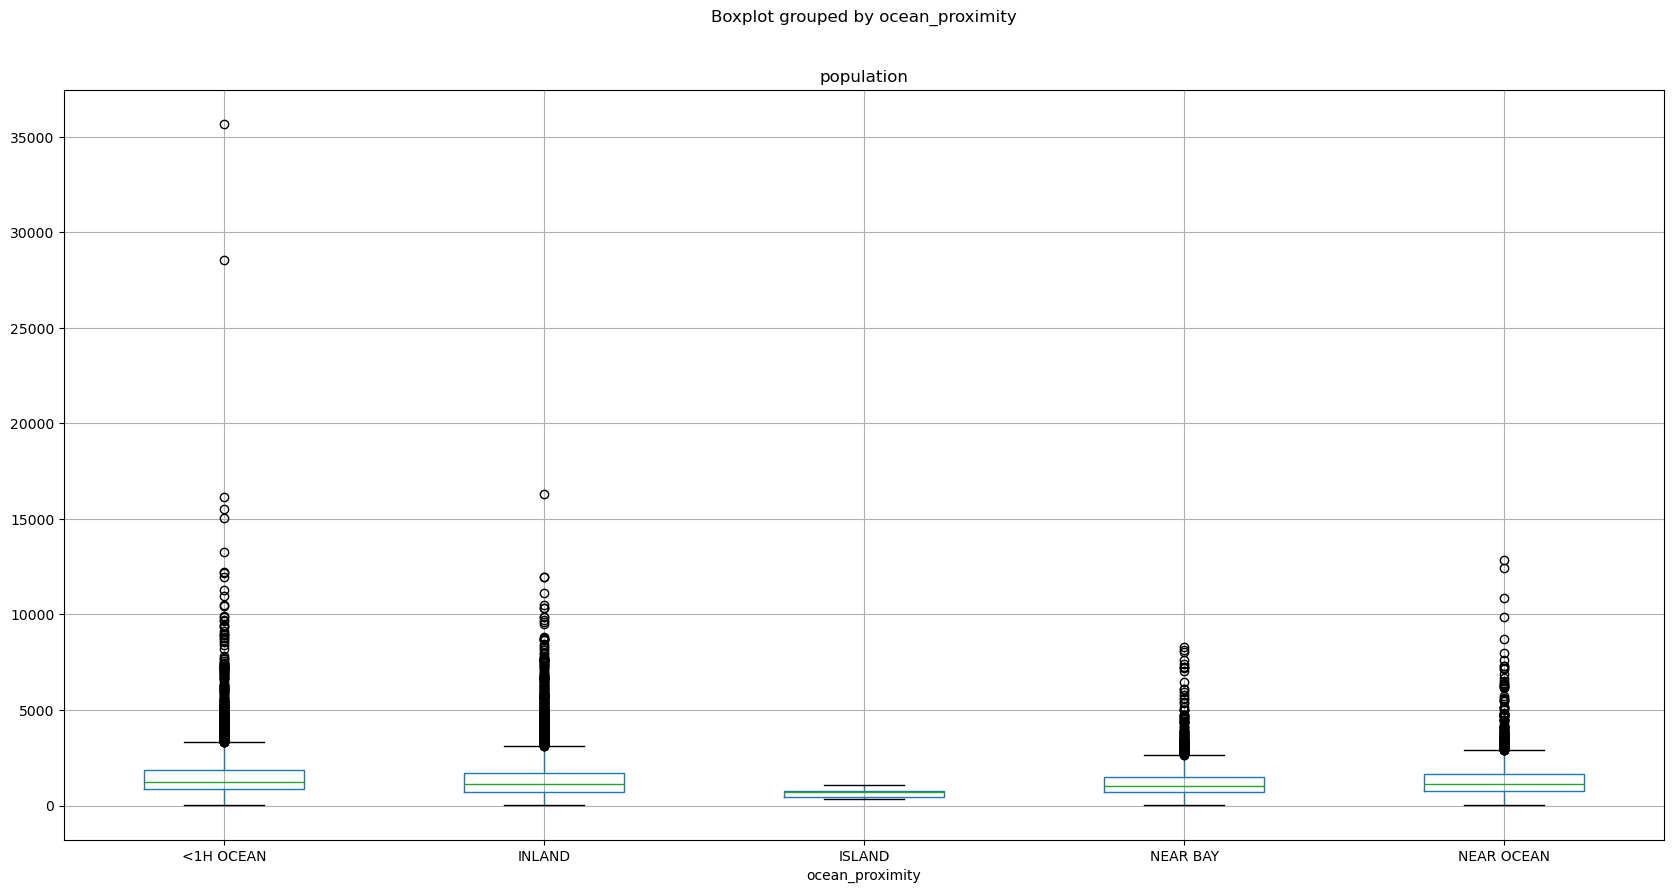

In [23]:
ca_housing_data.boxplot(column="population", by="ocean_proximity", figsize=(20,10))

plt.show()